In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [2]:
class SeqData1D:
    def __init__(self, seq, t_size=5, batch_size=32, normalize=False, 
                 shuffle=False, drop_remainder = False):
        '''
        paths: 文件路径
        '''
        self._data = list()
        self._target = list()
        self._n_samples = 0

        self._idx = 0    # mini-batch的游标
        self._batch_size = batch_size
        self._drop_flag=drop_remainder

        self._load(seq)

        if shuffle:
            self._shuffle_data()
        if normalize:
            self._normalize_data()

        print(self._data.shape, self._target.shape)

    def _load(self, seq):
        '''
        载入数据
        '''
        n_windows = len(seq)//t_size    # 无重叠的窗口数
        X = [seq[i*t_size:(i+1)*t_size] for i in range(n_windows)]
        Y = [seq[(i+1)*t_size] for i in range(n_windows)]

        # RNN的输入数据维度应为(n_samples,t_size,n_features)
        self._data = np.reshape(X, (-1, t_size, 1))

        # target维度(n_samples,n_outputs)
        self._target = np.reshape(Y, (-1, 1))

        self._n_samples = self._data.shape[0]

    def _shuffle_data(self):
        '''
        打乱数据
        '''
        idxs = np.random.permutation(self._n_samples)
        self._data = self._data[idxs]
        self._target = self._target[idxs]

    def _normalize_data(self):
        scaler = StandardScaler()
        self._data = scaler.fit_transform(self._data)

    def next_batch(self):
        '''
        生成mini-batch
        '''
        while self._idx < self._n_samples:
            if not self._drop_flag or self._n_samples-self._idx>=self._batch_size:
                yield self._data[self._idx: (self._idx+self._batch_size)], self._target[self._idx: (self._idx+self._batch_size)]
                self._idx += self._batch_size
            else:
                break
                
        self._idx = 0
        self._shuffle_data()

In [3]:
t_size = 5
batch_size = 32

seq = np.sin(np.linspace(0, 20*2*np.pi, 1002))    # 100个周期采样1002个点，1002只是为了便于分割
train_data = SeqData1D(seq[:801], t_size=t_size, batch_size=batch_size,drop_remainder=True)
test_data = SeqData1D(seq[801:], t_size=t_size, batch_size=batch_size,drop_remainder=True)

(160, 5, 1) (160, 1)
(40, 5, 1) (40, 1)


## 搭建网络

In [4]:
unit_I = 1    # 单特征
unit_h = 64
unit_O = 1    # 单输出

In [5]:
class MyMod:
    def __init__(self):
        X=keras.Input(shape=(t_size, unit_I),batch_size=32)
        lstm_layer_1 = keras.layers.LSTMCell(unit_h)
        lstm_layer_2 = keras.layers.LSTMCell(unit_h)
        lstm_layers = keras.layers.StackedRNNCells([lstm_layer_1,lstm_layer_2])
        rnn=keras.layers.RNN(lstm_layers,
                                      return_sequences=False,
                                      stateful=True)(inputs=X)
        pred=keras.layers.Dense(unit_O,activation=None)(inputs=rnn)
        self.model = keras.Model(inputs=X, outputs=pred)

model=MyMod().model
model.reset_states()

In [6]:
loss_object = tf.keras.losses.MeanSquaredError()
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

optimizer = tf.keras.optimizers.Adam()

In [7]:
@tf.function
def train_step(X, labels):
  with tf.GradientTape() as tape:
    predictions = model(X)    # ()
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)    # automatic differentiation
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
    
@tf.function
def test_step(X, labels):
  predictions = model(X)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)

@tf.function
def predict(inputs):
    return model(inputs)

In [8]:
epochs = 1000
template = 'Epoch {}, Loss: {}, Test Loss: {}'

for epoch in range(epochs):
    for batch_data, batch_labels in train_data.next_batch():
        train_step(batch_data,batch_labels)
        
    for test_batch_data, test_batch_labels in test_data.next_batch():
        test_step(test_batch_data,test_batch_labels)
            
    if epoch%100==0:
        print(template.format(epoch+1,train_loss.result(),test_loss.result()))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.43242892622947693, Test Loss: 0.4423045516014099
Epoch 101, Loss: 0.023224875330924988, Test Loss: 0.02146006189286709
Epoch 201, Loss: 0.011695710942149162, Test Loss: 0.010808744467794895
Epoch 301, Loss: 0.007826700806617737, Test Loss: 0.007235431112349033
Epoch 401, Loss: 0.005886286497116089, Test Loss: 0.005442763678729534
Epoch 501, Loss: 0.0047225430607795715, Test Loss: 0.004368189722299576
Epoch 601, Loss: 0.003950337413698435, Test Loss: 0.0036549975629895926
Epoch 701, Loss

<Figure size 432x288 with 0 Axes>

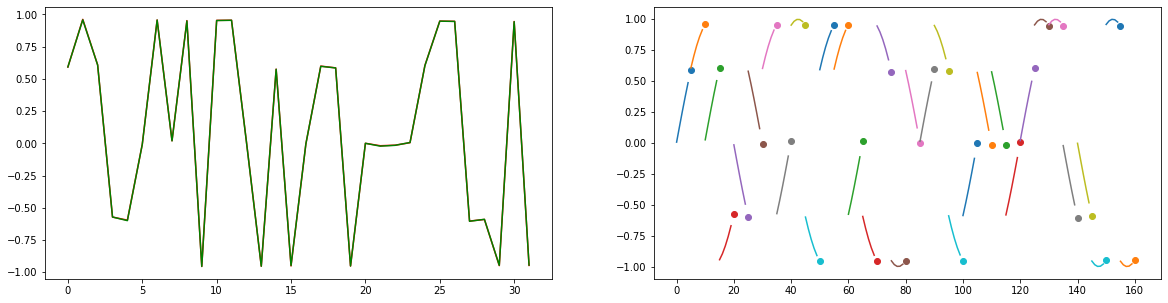

In [11]:
import numpy as np

X_test = np.array([])
Y_test = np.array([])
Y_pred = np.array([])
for test_batch_data, test_batch_labels in test_data.next_batch():
    X_test = np.append(X_test, test_batch_data)
    Y_test = np.append(Y_test, test_batch_labels)
    Y_pred = predict(test_batch_data)
    
import matplotlib.pyplot as plt
plt.clf()

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(Y_pred, c='r')
axs[0].plot(Y_test, c='g')

for idx in range(len(Y_pred)):    # 因为测试样本是打乱的，只能以时间窗口为单位绘制
    axs[1].plot(range(idx*5, (idx+1)*5), X_test[idx*5:(idx+1)*5])
    axs[1].scatter((idx+1)*5, Y_pred[idx])

plt.show()